In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [60]:
def load():
    data = pd.read_csv("diabetes.csv")
    return data

df = load()

In [61]:
df.shape

(768, 9)

In [62]:
df.head(6)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0


In [5]:
df.info

<bound method DataFrame.info of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   5

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
df.describe([0, 0.05, 0.50, 0.95, 0.99, 1])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
0%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
5%,0.000000,79.000000,38.700000,0.000000,0.000000,21.800000,0.140350,21.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
95%,10.000000,181.000000,90.000000,44.000000,293.000000,44.395000,1.132850,58.000000,1.000000
99%,13.000000,196.000000,106.000000,51.330000,519.900000,50.759000,1.698330,67.000000,1.000000
100%,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print()
    return cat_cols, num_cols, cat_but_car

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1



In [11]:
print(f"How many empty values for each column: \n{df.isnull().sum()}\n")

How many empty values for each column: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64



In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [13]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [14]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [15]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [16]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [17]:
keep_columns_same = ["Pregnancies", "Outcome"]

In [18]:
zero_to_nan = [col for col in df.columns if col not in keep_columns_same]

In [19]:
for col in zero_to_nan:
    df[col] = df[col].replace(0, np.nan)

In [20]:
def fill_with_mean(item, col, mean_of_zeros, mean_of_ones):
    if item["Outcome"] == 0 and pd.isna(item[col]):
        return mean_of_zeros
    elif item["Outcome"] == 1 and pd.isna(item[col]):
        return mean_of_ones
    else:
        return item[col]

In [21]:
for col in cat_cols:
    print(df.groupby(col)["Outcome"].mean())

Outcome
0    0.0
1    1.0
Name: Outcome, dtype: float64


In [22]:
for col in num_cols:
    print(df.groupby("Outcome")[col].mean())

Outcome
0    3.298000
1    4.843284
Name: Pregnancies, dtype: float64
Outcome
0    110.202750
1    141.534515
Name: Glucose, dtype: float64
Outcome
0    69.508000
1    72.880597
Name: BloodPressure, dtype: float64
Outcome
0    27.235457
1    32.894444
Name: SkinThickness, dtype: float64
Outcome
0    123.321496
1    184.679808
Name: Insulin, dtype: float64
Outcome
0    30.527500
1    35.105597
Name: BMI, dtype: float64
Outcome
0    0.420264
1    0.531022
Name: DiabetesPedigreeFunction, dtype: float64
Outcome
0    31.135000
1    37.052239
Name: Age, dtype: float64


In [23]:
for col in zero_to_nan:
    means_df = df.groupby("Outcome")[col].mean()
    mean_of_zero_outcomes = means_df.values[0]
    mean_of_one_outcomes = means_df.values[1]
    df[col] = df.apply(lambda x: fill_with_mean(x, col, mean_of_zero_outcomes, mean_of_one_outcomes), axis=1)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1


In [24]:
for col in df.columns:
    print(f"{col} has outlier: {check_outlier(df, col)}")

for col in df.columns:
    print(f"{col} has outliers at index: {grab_outliers(df, col, index=True)}")

Pregnancies has outlier: False
Glucose has outlier: False
BloodPressure has outlier: False
SkinThickness has outlier: True
Insulin has outlier: True
BMI has outlier: False
DiabetesPedigreeFunction has outlier: False
Age has outlier: False
Outcome has outlier: False
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Pregnancies has outliers at index: Int64Index([], dtype='int64')
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Glucose has outliers at index: Int64Index([], dtype='int64')
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
BloodPressure has outliers at index: Int64Index([], dtype='int64')
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
8           2.0    197.0           70.0   

In [25]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
np.sort(df_scores)

array([-2.52239323, -2.51323703, -2.31363745, -2.1657635 , -1.88972348,
       -1.88971516, -1.82477396, -1.72006952, -1.70803312, -1.64996711,
       -1.61790387, -1.58350764, -1.57823493, -1.57252403, -1.57088691,
       -1.56348624, -1.5547967 , -1.53227671, -1.52070854, -1.50562745,
       -1.49715919, -1.49381992, -1.47340808, -1.44539367, -1.43136517,
       -1.42940975, -1.42552765, -1.42481878, -1.41440709, -1.40609795,
       -1.40247662, -1.40029059, -1.39585774, -1.39438885, -1.38540121,
       -1.37424495, -1.36916878, -1.36801415, -1.36761324, -1.36187261,
       -1.36111081, -1.35818082, -1.35614709, -1.35126422, -1.34880895,
       -1.3485025 , -1.34759562, -1.34665408, -1.3460657 , -1.34546631,
       -1.34317254, -1.34306522, -1.34191638, -1.33812978, -1.33766853,
       -1.33697073, -1.33482741, -1.33180313, -1.3304578 , -1.32984822,
       -1.32856244, -1.32647288, -1.32436864, -1.32184914, -1.32138134,
       -1.32087114, -1.31865542, -1.3112162 , -1.31032325, -1.30

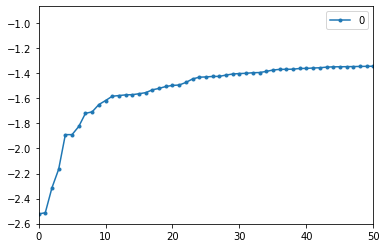

In [26]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show(block=True)

In [27]:
th = np.sort(df_scores)[12]

In [28]:
th

-1.578234931413074

In [29]:
df[df_scores < th].shape

(12, 9)

In [30]:
df[df_scores < th].index

Int64Index([75, 120, 182, 323, 342, 349, 445, 453, 502, 537, 579, 711], dtype='int64')

In [31]:
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)

In [32]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1


In [33]:
df['NewGlucose'] = pd.cut(x=df['Glucose'], bins=[0, 70, 99, 126, 200], labels=["Low", "Normal", "Secret", "High"])

In [34]:
df['NewBMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=["Underweight", "Normal", "Overweight", "Obese"])

In [35]:
df.loc[(15 <= df['Insulin']) & (df['Insulin'] <= 166), 'NewInsulin'] = 'Normal'

In [36]:
df.loc[166 < df['Insulin'], 'NewInsulin'] = 'Abnormal'

In [37]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose,NewBMI,NewInsulin
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1,High,Obese,Abnormal
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0,Normal,Overweight,Normal
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1,High,Normal,Abnormal
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,Normal,Overweight,Normal
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1,High,Obese,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0,Secret,Obese,Abnormal
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0,Secret,Obese,Normal
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0,Secret,Overweight,Normal
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1,Secret,Obese,Abnormal


In [38]:
encoded_df = pd.get_dummies(df, drop_first=True)

In [39]:
encoded_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High,NewBMI_Normal,NewBMI_Overweight,NewBMI_Obese,NewInsulin_Normal
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1,0,0,1,0,0,1,0
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0,1,0,0,0,1,0,1
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1,0,0,1,1,0,0,0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,1,0,0,0,1,0,1
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0,0,1,0,0,0,1,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0,0,1,0,0,0,1,1
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0,0,1,0,0,1,0,1
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1,0,1,0,0,0,1,0


In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(encoded_df)

Observations: 756
Variables: 16
cat_cols: 8
num_cols: 8
cat_but_car: 0
num_but_cat: 8



In [41]:
scaler = MinMaxScaler()
encoded_df[num_cols] = scaler.fit_transform(encoded_df[num_cols])

In [42]:
encoded_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High,NewBMI_Normal,NewBMI_Overweight,NewBMI_Obese,NewInsulin_Normal
0,0.444444,0.670968,0.513889,0.528302,0.559768,0.544355,0.489305,0.637363,1,0,0,1,0,0,1,0
1,0.074074,0.264516,0.430556,0.415094,0.357349,0.356183,0.243316,0.219780,0,1,0,0,0,1,0,1
2,0.592593,0.896774,0.402778,0.488574,0.559768,0.267473,0.529412,0.241758,1,0,0,1,1,0,0,0
3,0.074074,0.290323,0.430556,0.301887,0.260619,0.396505,0.079323,0.000000,0,1,0,0,0,1,0,1
4,0.000000,0.600000,0.069444,0.528302,0.504742,0.799731,1.000000,0.263736,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.740741,0.367742,0.569444,0.773585,0.544330,0.525538,0.082888,0.923077,0,0,1,0,0,0,1,0
764,0.148148,0.503226,0.486111,0.377358,0.357349,0.630376,0.233512,0.131868,0,0,1,0,0,0,1,1
765,0.370370,0.496774,0.513889,0.301887,0.320000,0.345430,0.148841,0.197802,0,0,1,0,0,1,0,1
766,0.074074,0.529032,0.347222,0.488574,0.559768,0.450269,0.241533,0.571429,1,0,1,0,0,0,1,0


In [43]:
corr = encoded_df.corr()

In [44]:
sns.set(rc={'figure.figsize': (12, 12)})

<AxesSubplot:>

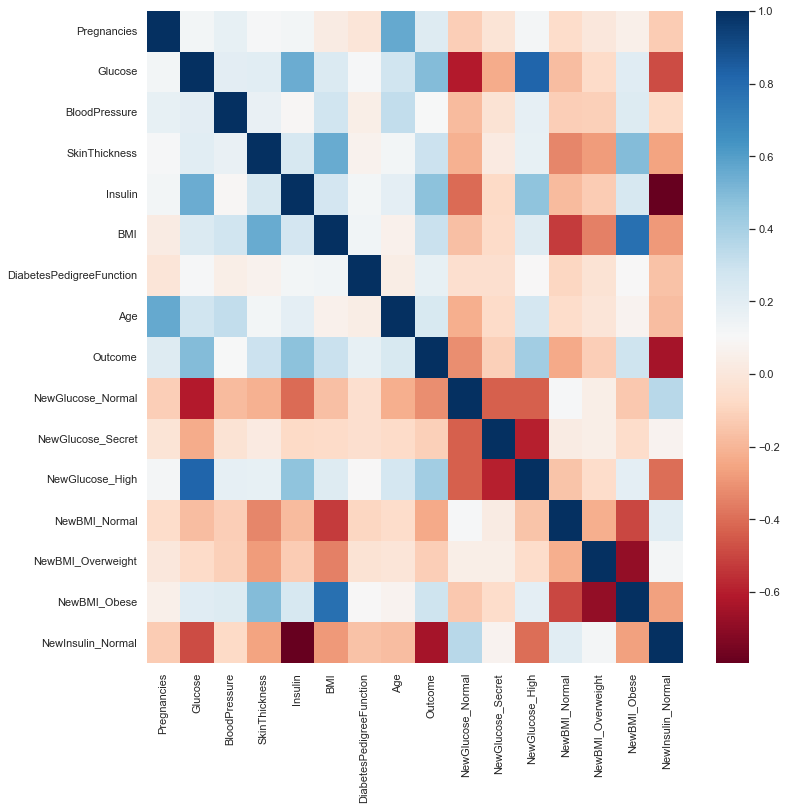

In [45]:
sns.heatmap(corr, cmap="RdBu")

In [46]:
y = encoded_df["Outcome"]
X = encoded_df.drop("Outcome", axis=1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
model = GradientBoostingClassifier(random_state=42)

In [52]:
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [53]:
y_pred = model.predict(X_test)

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score

In [65]:
print(f'Average accuracy is: {cross_val_score(model, X, y, cv=5).mean()}')

Average accuracy is: 0.8809515510630881


In [66]:
(f'Average F1 score is: {cross_val_score(model, X, y, scoring="f1", cv=5).mean()}')

'Average F1 score is: 0.8242024124742571'